In [1]:
from field_util import Field, CartCoord, compare_fields_general

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates.matrix_utilities import rotation_matrix
import numpy as np
from scipy import ndimage
import copy
from matplotlib.colors import LogNorm as LogNorm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd
import os

from matplotlib.backends.backend_pdf import PdfPages

In [14]:
import matplotlib as mpl

mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth'] = 2

#cosmetics
mpl.rc('text', usetex=True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 23
})

In [3]:
# TODO:
# show how we process the data
# Ingredients:
# CLAMATO, 2980 raw density, 2980 FPGA+RSD, 2980 reconstruction

In [4]:
cosmo = FlatLambdaCDM(H0=100* u.km / u.s / u.Mpc, Om0=0.315) # Metin original
mycoord = CartCoord(150.14205192829834, 2.224237689411875, cosmo) # Used in Cosmic Birth

cata_path = '../Catalogs/'
data_path = '../Data/'
plot_path = '../Plot/'

In [5]:
R_tophat = 4 * u.Mpc

# clamato
clamato_path = '../Data/CLAMATO/map_2020_v0.bin'
delta_clm_real = np.fromfile(clamato_path, dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
delta_clm_real = delta_clm_real[::1,::-1,::1] 
# this reversal is due to the coordinate in clamato is 
#    x - ra     y - dec
#    0 - 149.89 0 - 2.07
#    68 - 150.4 56 - 2.50  
# consistent with https://github.com/kheegan/preheating2019
x_0, y_0, z_0 = mycoord.orig_to_box(149.89, 2.07, 2.05)
CLAMATO_field = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_clm_real)
#res = CLAMATO_field.smooth_tophat_fft(R_tophat)
res = CLAMATO_field.smooth(R_tophat)

# reconstruction
delta_rec_mock = np.fromfile(data_path+"rec_field_sim/pixel_data_RUN11_2980_3_true_SNR.bin_map.bin", dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
delta_rec_mock = delta_rec_mock[::1,::-1,::1] 
rec_field = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_rec_mock)
# res = rec_field.smooth_tophat_fft(R_tophat)
res = rec_field.smooth(R_tophat)


x0, y0, z0 = 3550*u.Mpc, -50*u.Mpc, -50*u.Mpc
dl = 2*u.Mpc

# matter
dens_m_2980 = np.load(data_path+"lores/RUN11_2980_256.00103lowres_density.npy")[:, ::-1, :]
opdelta_m_2980 = dens_m_2980 / np.mean(dens_m_2980)
opdelta_m_field = Field(x0, y0, z0, dl, opdelta_m_2980)
# res = opdelta_m_field.smooth_tophat_fft(R_tophat) # 1 + delta_m
res = opdelta_m_field.smooth(R_tophat) # 1 + delta_m

# FGPA + RSD
tau_2980 = np.load(data_path+"lores/RUN11_2980_256.00103lowres_tau.npy")[:, ::-1, :]
F_2980 = np.exp(-tau_2980)
delta_F_2980 = F_2980 / np.mean(F_2980) - 1
delta_F_field = Field(x0, y0, z0, dl, delta_F_2980)
# res = delta_F_field.smooth_tophat_fft(R_tophat)
res = delta_F_field.smooth(R_tophat)


In [6]:
def compare_fields_general(field_1, field_2, extent, ncell_1, ncell_2, vmin = 2e-3, vmax = 100, countour = True):
    # from Metin 2019
    '''
    extent = [x_1, y_1, x_2, y_2]
    '''
    # fig = plt.figure(figsize = (10, 10))
    
    x_1, y_1, x_2, y_2 = extent
    
    bins_1 = np.linspace(x_1, x_2, ncell_1)
    bins_2 = np.linspace(y_1, y_2, ncell_2)
    
    hist2d, edges_1, edges_2 = np.histogram2d(np.ndarray.flatten(field_1.field_data), np.ndarray.flatten(field_2.field_data), 
                                bins=[bins_1, bins_2],density=True)
    
    X, Y = np.meshgrid(edges_1,  edges_2, indexing='ij')
    plt.pcolormesh(X,Y, hist2d, cmap='Greys',
                  norm=LogNorm(vmin=vmin, vmax=vmax))
    
    #cbar = plt.colorbar()
    #cbar.set_label('normalized density')
    
    XCon, YCon = np.meshgrid(edges_1[0:-1]+(edges_1[1]-edges_1[0])/2 , 
                             edges_2[0:-1]+(edges_2[1]-edges_2[1])/2 , 
                             indexing='ij')
    
    if countour:
        plt.contour(XCon,YCon, hist2d, levels = 5)
    return None

def compare_fields_direct(data_1, data_2, extent, ncell_1, ncell_2, vmin = 0.02, vmax = 500, countour = True):
    # from Metin 2019
    '''
    extent = [x_1, y_1, x_2, y_2]
    '''
    # fig = plt.figure(figsize = (10, 10))
    
    x_1, y_1, x_2, y_2 = extent
    
    bins_1 = np.linspace(x_1, x_2, ncell_1)
    bins_2 = np.linspace(y_1, y_2, ncell_2)
    
    hist2d, edges_1, edges_2 = np.histogram2d(data_1, data_2, 
                                bins=[bins_1, bins_2],density=True)
    
    X, Y = np.meshgrid(edges_1,  edges_2, indexing='ij')
    plt.pcolormesh(X,Y, hist2d, cmap='Greys',
                  norm=LogNorm(vmin=vmin, vmax=vmax))
    
    #cbar = plt.colorbar()
    #cbar.set_label('normalized density')
    
    XCon, YCon = np.meshgrid(edges_1[0:-1]+(edges_1[1]-edges_1[0])/2 , 
                             edges_2[0:-1]+(edges_2[1]-edges_2[1])/2 , 
                             indexing='ij')
    

    if countour:
        plt.contour(XCon,YCon, hist2d, levels = 3)
    return None

def compare_fields_contour(field_1, field_2, extent, ncell_1, ncell_2, vmin = 1, vmax = 100, countour = True):
    # from Metin 2019
    '''
    extent = [x_1, y_1, x_2, y_2]
    '''
    # fig = plt.figure(figsize = (10, 10))
    
    x_1, y_1, x_2, y_2 = extent
    
    bins_1 = np.linspace(x_1, x_2, ncell_1)
    bins_2 = np.linspace(y_1, y_2, ncell_2)
    
    hist2d, edges_1, edges_2 = np.histogram2d(np.ndarray.flatten(field_1.field_data), np.ndarray.flatten(field_2.field_data), 
                                bins=[bins_1, bins_2],density=True)

    XCon, YCon = np.meshgrid(edges_1[0:-1]+(edges_1[1]-edges_1[0])/2 , 
                             edges_2[0:-1]+(edges_2[1]-edges_2[1])/2 , 
                             indexing='ij')
    
    if countour:
        plt.contour(XCon,YCon, hist2d, levels = [0.1, 0.3, 1, 3, 10])
    return None

In [7]:
mycoord.add_field(opdelta_m_field)
opd_field_map = mycoord.map_data(CLAMATO_field)
mycoord.add_field(delta_F_field)
delta_F_map = mycoord.map_data(CLAMATO_field)

/Users/dongcz/Work/COSMOS_Preheating/Code/field_util.py:37: UserWarning: Warning: Index out of boundary
  warnings.warn("Warning: Index out of boundary")


In [8]:
beta = 1.6
A_norm = 0.16

In [9]:
# Generate a 4.5 Mpc sphere mask

field = CLAMATO_field
COSTCO_meta = pd.read_csv(cata_path+'COSTCO_metadata.csv')
pc = COSTCO_meta.iloc[10]
x, y, z = mycoord.orig_to_box(pc['RA'], pc['DE'], pc['z_obs'])

s = field.field_data.shape
radius = 4.5 * u.Mpc
radius_pix = (radius / field.dl).value
x_pc, y_pc, z_pc = mycoord.orig_to_box(pc['RA'], pc['DE'], pc['z_obs'])


grid = np.array(np.meshgrid(np.arange(s[0]), np.arange(s[1]), np.arange(s[2]), indexing='ij'))
grid_coord = field.index2coord(grid[0], grid[1], grid[2])
mask_sph_highres = ((grid_coord[0]- x_pc)**2+ (grid_coord[1]- y_pc)**2+(grid_coord[2]- z_pc)**2) < radius**2

In [10]:
mask_sph = mask_sph_highres

/var/folders/fh/40jp8wfn3mj0b1zvxs50dhl00000gn/T/ipykernel_46257/1992724864.py:8: RuntimeWarning: invalid value encountered in power
  plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
/var/folders/fh/40jp8wfn3mj0b1zvxs50dhl00000gn/T/ipykernel_46257/1992724864.py:19: RuntimeWarning: invalid value encountered in power
  plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
/var/folders/fh/40jp8wfn3mj0b1zvxs50dhl00000gn/T/ipykernel_46257/1992724864.py:32: RuntimeWarning: invalid value encountered in power
  plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
/var/folders/fh/40jp8wfn3mj0b1zvxs50dhl00000gn/T/ipykernel_46257/1992724864.py:45: RuntimeWarning: invalid value encountered in power
  plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
/var/folders/fh/40jp8wfn3mj0b1zvxs50dhl00000gn/T/ipykernel_46257/1992724864.py:56: RuntimeWarning: invalid value encountered in power
  plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
/var/f

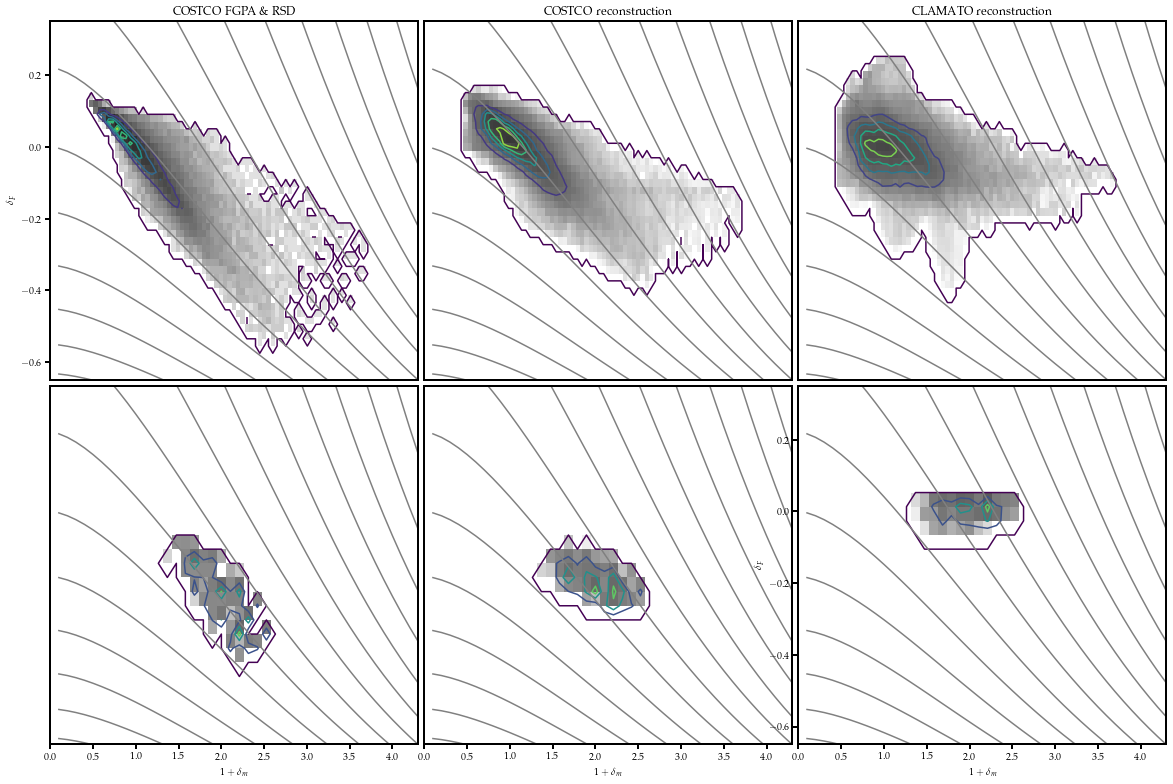

In [11]:
fig = plt.figure(figsize=(20, 13.3))
grid = plt.GridSpec(20, 30)

plt.subplot(grid[0:10, 0:10])
fig = compare_fields_general(opd_field_map, delta_F_map, [0, -1, 5, 1], 100, 100)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.xlim(0, 4.3)
plt.ylim(-0.65, 0.35)
plt.xticks([])
plt.ylabel("$\\delta_F$")
plt.title("COSTCO FGPA \& RSD")

plt.subplot(grid[0:10, 10:20])
fig = compare_fields_general(opd_field_map, rec_field, [0, -1, 5, 1], 100, 100)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.xlim(0, 4.3)
plt.ylim(-0.65, 0.35)
plt.xticks([])
plt.yticks([])
plt.title("COSTCO reconstruction")



plt.subplot(grid[0:10, 20:30])
fig = compare_fields_general(opd_field_map, CLAMATO_field, [0, -1, 5, 1], 100, 100)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.ylim(-0.65, 0.35)
plt.xlim(0, 4.3)
plt.xlabel("$1 +\\delta_m$")
plt.xticks([])
plt.yticks([])
plt.title("CLAMATO reconstruction")

# local
plt.subplot(grid[10:20, 0:10])
fig = compare_fields_direct(opd_field_map.field_data[mask_sph], delta_F_map.field_data[mask_sph], [1, -0.5, 3, 0.25], 20, 20)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.xlim(0, 4.3)
plt.ylim(-0.65, 0.35)
plt.ylabel("$\\delta_F$")
plt.xlabel("$1 +\\delta_m$")


plt.subplot(grid[10:20, 10:20])
fig = compare_fields_direct(opd_field_map.field_data[mask_sph], rec_field.field_data[mask_sph], [1, -0.5, 3, 0.25], 20, 20)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.xlim(0, 4.3)
plt.ylim(-0.65, 0.35)
plt.yticks([])
plt.xlabel("$1 +\\delta_m$")


plt.subplot(grid[10:20, 20:30])
fig = compare_fields_direct(opd_field_map.field_data[mask_sph], CLAMATO_field.field_data[mask_sph], [1, -0.5, 3, 0.25], 20, 20)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.ylim(-0.65, 0.35)
plt.xlim(0, 4.3)
plt.yticks([])
plt.xlabel("$1 +\\delta_m$")

pdf_pages = PdfPages('Transmission_density.pdf')
pdf_pages.savefig(fig, pad_inches = 0)
pdf_pages.close()


/var/folders/fh/40jp8wfn3mj0b1zvxs50dhl00000gn/T/ipykernel_46257/7767449.py:8: RuntimeWarning: invalid value encountered in power
  plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
/var/folders/fh/40jp8wfn3mj0b1zvxs50dhl00000gn/T/ipykernel_46257/7767449.py:20: RuntimeWarning: invalid value encountered in power
  plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
/var/folders/fh/40jp8wfn3mj0b1zvxs50dhl00000gn/T/ipykernel_46257/7767449.py:33: RuntimeWarning: invalid value encountered in power
  plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
/var/folders/fh/40jp8wfn3mj0b1zvxs50dhl00000gn/T/ipykernel_46257/7767449.py:49: RuntimeWarning: invalid value encountered in power
  plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
/var/folders/fh/40jp8wfn3mj0b1zvxs50dhl00000gn/T/ipykernel_46257/7767449.py:62: RuntimeWarning: invalid value encountered in power
  plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
/var/folders/fh/40jp8

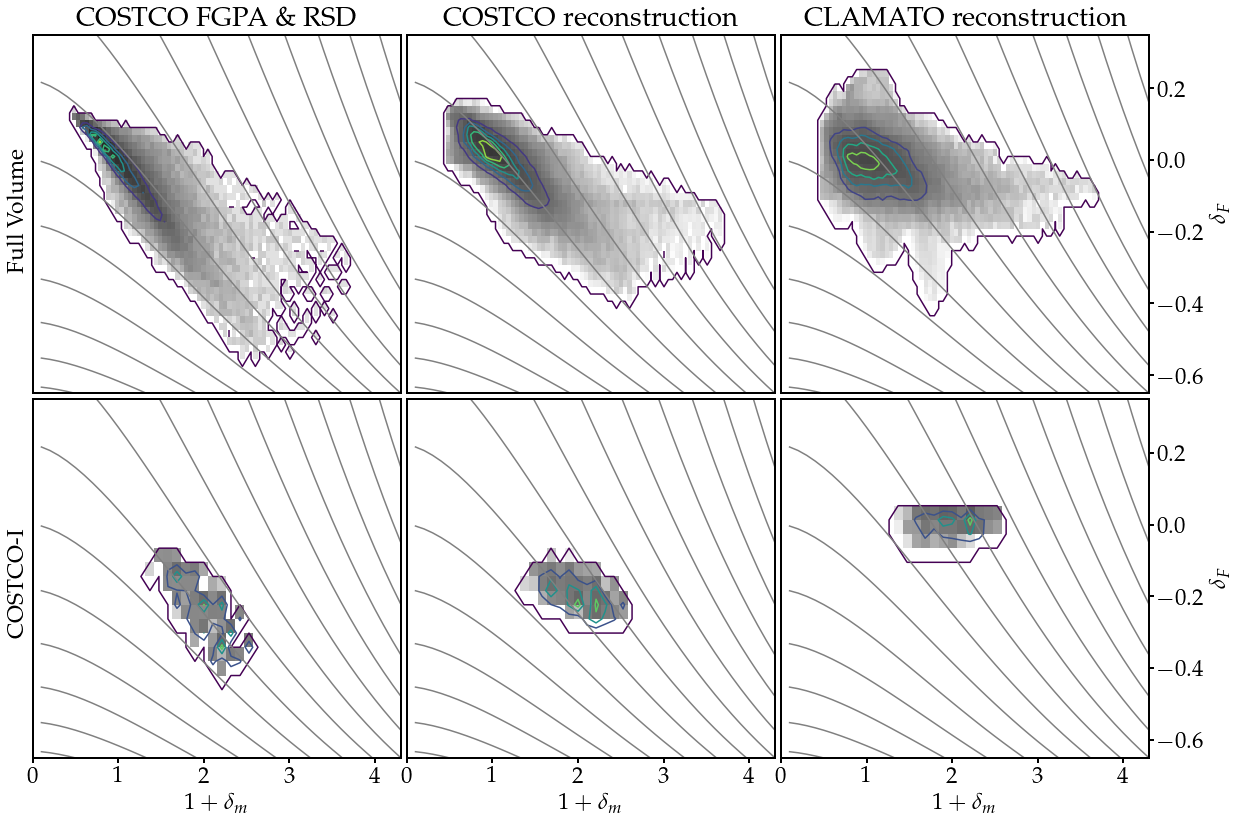

In [26]:
fig = plt.figure(figsize=(20, 13.3))
grid = plt.GridSpec(20, 30)

plt.subplot(grid[0:10, 0:10])
fig = compare_fields_general(opd_field_map, delta_F_map, [0, -1, 5, 1], 100, 100)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.xlim(0, 4.3)
plt.ylim(-0.65, 0.35)
plt.xticks([])
plt.yticks([])
plt.title("COSTCO FGPA \& RSD")
plt.text(-0.3, -0.3, 'Full Volume', rotation = 90)

plt.subplot(grid[0:10, 10:20])
fig = compare_fields_general(opd_field_map, rec_field, [0, -1, 5, 1], 100, 100)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.xlim(0, 4.3)
plt.ylim(-0.65, 0.35)
plt.xticks([])
plt.yticks([])
plt.title("COSTCO reconstruction")



plt.subplot(grid[0:10, 20:30])
fig = compare_fields_general(opd_field_map, CLAMATO_field, [0, -1, 5, 1], 100, 100)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.ylim(-0.65, 0.35)
plt.xlim(0, 4.3)
plt.xlabel("$1 +\\delta_m$")
plt.xticks([])
plt.yticks([])
plt.title("CLAMATO reconstruction")
plt.gca().twinx()
plt.ylim(-0.65, 0.35)
plt.ylabel("$\\delta_F$")

# local
plt.subplot(grid[10:20, 0:10])
fig = compare_fields_direct(opd_field_map.field_data[mask_sph], delta_F_map.field_data[mask_sph], [1, -0.5, 3, 0.25], 20, 20)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.xlim(0, 4.3)
plt.ylim(-0.65, 0.35)
plt.yticks([])
plt.xlabel("$1 +\\delta_m$")
plt.text(-0.3, -0.3, 'COSTCO-I', rotation = 90)



plt.subplot(grid[10:20, 10:20])
fig = compare_fields_direct(opd_field_map.field_data[mask_sph], rec_field.field_data[mask_sph], [1, -0.5, 3, 0.25], 20, 20)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.xlim(0, 4.3)
plt.ylim(-0.65, 0.35)
plt.yticks([])
plt.xlabel("$1 +\\delta_m$")


plt.subplot(grid[10:20, 20:30])
fig = compare_fields_direct(opd_field_map.field_data[mask_sph], CLAMATO_field.field_data[mask_sph], [1, -0.5, 3, 0.25], 20, 20)
x = np.arange(-5, 5, 0.1) # 1 + delta
for B in np.arange(-3, 3, 0.2):
    plt.plot(x, np.exp(B)*np.exp(-A_norm*x**beta)-1, color='grey')
plt.ylim(-0.65, 0.35)
plt.xlim(0, 4.3)
plt.yticks([])
plt.xlabel("$1 +\\delta_m$")
plt.gca().twinx()
plt.ylim(-0.65, 0.35)
plt.ylabel("$\\delta_F$")



pdf_pages = PdfPages('Transmission_density.pdf')
pdf_pages.savefig(fig, pad_inches = 0)
pdf_pages.close()


In [48]:
(opd_field_map.field_data[mask_sph].size / 3) / 40 / 40

2.836041666666667